# Семинар 8: Metric learning for face recognition

<img src="https://insightface.ai/assets/img/github/facerecognitionfromvideo.PNG" alt="drawing" width="800"/>

## Содержание семинара
На этом семинаре мы
1. Разберём Softmax функцию потерь, используемую для получения грубоких представлений.
2. Разберём пример обучения модели с помощью Triplet Loss
3. Визуализируем полученные представления и сравним методы Metric Learning
4. Поставим задачу распознавания лиц.
5. Опишем в общем виде pipeline для решения задачи распознавания.
6. Применим полученные знания для решения задачи распознавания лиц на наборе данных [EasyPortrait](https://github.com/ai-forever/easyportrait).
<!-- 7. Решим задачу открытой идентификации на наборе данных IJB-C -->

## 1. Обучение Softmax модели на небольшом наборе данных

При решении задачи распознавания лиц возникает необходимость ответить на вопрос: изображен ли на двух разных картинках один и тот же человек или нет?  
На этот вопрос можно ответить с помощью функции расстояния между изображениями, учитывающую абстрактную семантическую информацию.  

Современные методы распознавания лиц используют большие наборы данных, содержащие изображения разных людей, для обучения нейросетей, вычисляющих "осмысленные" вектора представлений изображений лиц.
Для каждого изображения лица человека $\textbf{x}$ с помощью обучаемой функции $f_{\theta}(*)$ вычисляется вектор представления $\textbf{x}$:
$$
\textbf{z} = f_{\theta}(\textbf{x})
$$
Параметры $\theta$ модели подбираются так, чтобы расстояние между векторами представлений изображений разных людей было велико, а между представлениями изображений одного и того же человека - низко:
$$
d(\textbf{z}_i,\textbf{z}_j)>>d(\textbf{z}_i,\textbf{z}'_i)
$$
где $\mathbf{id}(\textbf{x}_i)=\mathbf{id}(\textbf{x}'_i),\,\mathbf{id}(\textbf{x}_i)\neq\mathbf{id}(\textbf{x}_j)$, $d$ -- некоторая функция расстояния, например, косинусное расстояние:
$$
d(\textbf{z}_i,\textbf{z}_j) = -\frac{\langle\textbf{z}_i,\textbf{z}_j\rangle}{\left\lVert\textbf{z}_i\right\rVert\left\lVert\textbf{z}_j\right\rVert}
$$

Для получения искомых представлений можно решать задачу классификации на большом наборе данных с изображениями разных людей, а затем использовать вектор перед последним линейным слоем как вектор представления лица. 
В такой постановке каждый человек в наборе данных рассматривается как отдельный класс, а множество изображений его лица - как представители этого класса.

Для решения задачи многоклассовой классификации можно использовать стандартную Softmax функцию потерь:
$$
    L = -\frac{1}{N}\sum_{i=1}^N\log\frac{e^{W_{y_i}^T\textbf{z}_i + b_{y_i}}}{\sum_{j=1}^ne^{W_{j}^T\textbf{z}_i + b_{j}}}
$$
$\textbf{z}_i$ - представление изображения, $N$ - число изображений в мини батче, $W_j, b_j$ - параметры весов (гиперплоскости) для каждого класса.

Если мы отнормируем вектор $\textbf{x}$ так, чтобы он имел ограниченную норму $s$, положим норму вектора $W_j$ равную 1, а $b_j = 0$, то функция потерь может быть переписана в следующей форме:
$$
L = -\frac{1}{N}\sum_{i=1}^N
\log
\frac{e^{s\cos\theta_{y_i}}}
{e^{s\cos\theta_{y_i}} + \sum_{j\neq y_i}^ne^{s\cos\theta_{j}}},
$$
где $\theta_j$ - угол между представлением $i$-го изображения и вектором $W_j$ указывающим на центр $j$-ой класса. 

Мы можем видеть, что здесь максимизируется косинус угла между представлением и соответствующим вектором класса. 

In [19]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import mxnet as mx
import numbers
import math
import torch.nn.functional as F
from typing import Tuple, Optional, Dict, List
from tqdm import tqdm
import numpy as np
import os
from pathlib import Path

In [20]:
class ArcFaceDataset(Dataset):
    """
    ArcFace dataset loader,
    based on https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/dataset.py
    """

    def __init__(self, root_dir: str, num_labels: int, test: bool = False) -> None:
        """Initialize ArcFace Dataset.

        :param root_dir: path to the folder containing face images
        :param num_labels: number of classes (people) to be used
        :param test: if True, create test dataset (no augmentations, no labels)
        """
        super(ArcFaceDataset, self).__init__()

        self.test = test

        # for test dataset, use default transformations (conver to torch.Tensor and normalize),
        # do not use augmentations
        if self.test:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )

        # for train dataset, add augmentations of images (Random horizontal flip)
        else:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )

        self.root_dir = root_dir
        path_imgrec = os.path.join(root_dir, "train.rec")
        path_imgidx = os.path.join(root_dir, "train.idx")

        # load pictures
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, "r")
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)

        self.imgidx = np.array(range(1, int(header.label[0])))

        # load or create labels
        labels_path = Path(root_dir) / "labels.npy"
        if labels_path.is_file():
            self.labels = np.load(labels_path)
        else:
            print("Listing labels...")
            labels = []
            for i in tqdm(range(len(self.imgidx))):
                idx = self.imgidx[i]
                s = self.imgrec.read_idx(idx)
                header, img = mx.recordio.unpack(s)
                label = header.label
                labels.append(int(label))
            self.labels = np.array(labels)
            # save labels
            np.save(labels_path, self.labels)

        unique_labels, unique_counts = np.unique(self.labels, return_counts=True)
        top_ids = np.argsort(unique_counts)[::-1][:num_labels]
        self.top_labels = unique_labels[top_ids]

        self.label_map = dict(
            zip(self.top_labels.tolist(), np.arange(len(self.top_labels)))
        )

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Optional[int]]:
        """Get item of a dataset.

        :param index: index of an item
        :return:
            - a tuple (image, label) for the train dataset
            - image for tht test dataset
        """
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label

        if not isinstance(label, numbers.Number):
            label = label[0]

        label = self.label_map[int(label)]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()

        if self.transform is not None:
            sample = self.transform(sample)
        if self.test:
            return sample, label
        else:
            return sample, label

    def __len__(self) -> int:
        """Return size of the dataset."""
        return len(self.imgidx)

In [21]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
ms1m_dir = data_dir / "ms1m_subset"
#!wget -nc https://dl.dropboxusercontent.com/s/a53udei76f9h270/ms1m_subset.zip -O data/ms1m_subset.zip
#!unzip data/ms1m_subset.zip -d data

In [22]:
num_people = 8

dataset = ArcFaceDataset(ms1m_dir, num_labels=num_people)
people_ids = np.where(np.isin(dataset.labels, dataset.top_labels))[0]
people_set = torch.utils.data.Subset(dataset, people_ids)

In [31]:
# plt.imshow((people_set[0][0] * 255).permute((2, 1, 0)).numpy().astype('uint8'))

In [23]:
print("Dataset size:", len(people_set))

Dataset size: 4478


### Модель

Ниже определен класс для используемое модели. Для удобства обучения мы работаем с библиотекой pytorhc_lightning и испольщуем класс ```pl.LightningModule```.

In [32]:
class MetricLearningModel(pl.LightningModule):
    """Lightning wrapper for a Metric Learning model."""

    def __init__(
        self,
        backbone: torch.nn.Module,
        loss: torch.nn.Module,
        num_labels: int,
        trained_epochs: int = 0,
        model_name: str = "Model",
    ) -> None:
        """Initialize MetricLearningModel.

        :param backbone: core deef model to be trained
        :param loss: loss function to be used
        :param num_labels: number of target classes (people)
        """
        super().__init__()

        self.backbone = backbone
        self.loss = loss
        self.trained_epochs = trained_epochs
        self.model_name = model_name
        # parameters of the last linear layer initialized by the 'kaiming_uniform_'
        self.softmax_weights = torch.nn.Parameter(torch.empty((num_labels, 2)))
        torch.nn.init.kaiming_uniform_(self.softmax_weights, a=math.sqrt(5))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through the model.

        :param x: batch of images
        :return a tuple of:
            - features: outputs of the backbone model a.k.a. embeddings
            - logits: result of the last linear transformations
        """
        backbone_outputs = self.backbone(x)
        features = backbone_outputs["feature"]
        norm_weights = F.normalize(self.softmax_weights, dim=1)
        logits = F.linear(features, norm_weights)
        return features, logits

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """Do a training step of the model.

        :param batch: batch of input images
        :return: value of the loss function
        """
        images, labels = batch
        features, logits = self(images)
        loss = self.loss(logits, labels)
        # log loss value
        self.log("train_loss", loss.item(), prog_bar=True, logger=False)
        # self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self) -> Dict[str, torch.optim.Optimizer]:
        params = list(
            self.parameters()
        )  # + [self.softmax_weights] #list(self.linear_norm.parameters())
        optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=5e-5)
        return {
            "optimizer": optimizer,
        }

### Инициализация модели

В качестве backbone-модели предлагается использовать глубокую сверточную сеть iResNet50. С ее арзитектурой можно ознакомиться в модуле ```iresent.py```.
В первом эксперименте мы используем стандартную функцию потерь SoftMax, определенную в ```torch.nn```.
Для удобства визуализации мы используем пространство представлений размерности $2$ (```num_features=2```).

In [33]:
from iresnet import iresnet50_normalized, iresnet50

backbone_model = iresnet50_normalized(num_features=2)
softmax_loss = torch.nn.CrossEntropyLoss()

softmax_model = MetricLearningModel(
    backbone_model,
    softmax_loss,
    num_labels=num_people,
    model_name="Iresnet50n softmax loss",
)

In [34]:
batch_size = 128
num_workers = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# create train dataloader
train_dataloader = DataLoader(
    people_set,
    batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

# create test dataloader
test_dataloader = DataLoader(
    people_set,
    batch_size=50,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

cuda


In [35]:
# Определяем функцию для формирования данных с целью оценки модели


def predict_features(
    model: pl.LightningModule, test_dataloader: DataLoader, device: str = "cuda"
) -> Tuple[np.array, np.array]:
    """Transform images and get their embeddings.

    :param model: trained MetricLearningModel
    :param test_dataloader: DataLoader with images to be transformed
    :param device: 'gpu' or 'cuda', if available
    :return a tuple of:
        - numpy array with obtained features
        - true image labels (people id's)
    """
    model.to(device)

    # switch model to 'eval' mode: disable randomness, dropout, etc.
    model.eval()

    predicted_features = []
    image_labels = []

    loss = 0
    image_cnt = 0

    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        features, logits = model(images)
        loss += (
            model.loss(logits, labels.to(device)).detach().cpu().numpy()
            * labels.shape[0]
        )
        image_cnt += labels.shape[0]
        features = features.detach().cpu().numpy()
        labels = labels.numpy()
        predicted_features.append(features)
        image_labels.append(labels)

    predicted_features = np.concatenate(predicted_features)
    image_labels = np.concatenate(image_labels)
    loss = loss / image_cnt

    weights = model.softmax_weights.detach().cpu()
    weights = F.normalize(weights, dim=1).numpy()

    return (
        weights,
        predicted_features,
        image_labels,
        model.model_name,
        model.trained_epochs,
        loss,
    )

### Обучение модели c функцией потерь softmax

Обучаем модель и логируем её предсказания с шагом 20 эпох.
Для обучения используем интерфейс ```pytorch_lightning```.

In [11]:
softmax_predict_data = []

In [36]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

# fit the model with a softmax loss function
torch.set_float32_matmul_precision("medium")  # 'highest' , 'high' , 'medium'

max_epochs = 100
epochs_step = 20

for i in range(max_epochs // epochs_step):
    # initialize trainer, use one GPU for training
    trainer = Trainer(max_epochs=epochs_step, logger=False, enable_checkpointing=False)
    trainer.fit(softmax_model, train_dataloader)
    softmax_model.trained_epochs += epochs_step
    softmax_predict_data.append(
        predict_features(softmax_model, test_dataloader, device=device)
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | IResNetNorm      | 30.8 M
1 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
30.8 M    Trainable params
2         Non-trainable params
30.8 M    Total params
123.178   Total estimated model params size (MB)


Epoch 0:  97%|█████████▋| 33/34 [00:27<00:00,  1.18it/s, train_loss=1.690]

/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


NameError: name 'softmax_predict_data' is not defined

In [51]:
softmax_predict_data.append(
    predict_features(softmax_model, test_dataloader, device=device)
)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:13<00:00,  6.79it/s]


In [38]:
model_file = "data/softmax_model1.pt"
results_path = "data/softmax_predict_data.pkl"

In [15]:
import pickle

torch.save(softmax_model, model_file)
with open(results_path, "wb") as f:
    pickle.dump(softmax_predict_data, f)

In [39]:
softmax_model = torch.load(model_file)
with open(results_path, "rb") as f:
    softmax_predict_data = pickle.load(f)

### Получение представлений

Ниже приведена функция для получения представлений изображений из ```test_dataloader```.

In [40]:
# Ниже реализована функция для расчета среднего расстояния
# от представлений изображений одного класса до луча центра класса.


# Angle between vectors (distance between vectors)
def angle_between_vectors(v1, v2):
    return np.arccos(
        np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1, 1)
    )


# Average distance between points and class weight
def average_distance_w(weights, features, image_labels):
    distances = []
    for i, weight in enumerate(weights):
        points = features[image_labels == i]
        for point in points:
            distances.append(angle_between_vectors(weight, point))

    distances = np.array(distances)
    return distances[~np.isnan(distances)].mean()


# Average distance between points and class center
def average_distance(weights, features, image_labels):
    distances = []
    for i, weight in enumerate(weights):
        points = features[image_labels == i]
        if points.shape[1] == 2:
            center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
        if points.shape[1] == 3:
            center = [
                np.mean(points[:, 0]),
                np.mean(points[:, 1]),
                np.mean(points[:, 2]),
            ]
        center = center / np.linalg.norm(center)
        for point in points:
            distances.append(angle_between_vectors(center, point))

    distances = np.array(distances)
    return distances[~np.isnan(distances)].mean()


# STD distance between class centers
def std_between_class_centers(weights, features, image_labels):
    class_centers = []
    distances = []
    for i, weight in enumerate(weights):
        points = features[image_labels == i]
        center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
        center = center / np.linalg.norm(center)
        class_centers.append(center)

    angles = []
    for center in class_centers:
        angle = angle_between_vectors(center, [1, 0])
        if center[1] > 0:
            angle = np.pi + np.pi - angle
        angles.append(angle)

    class_centers = np.array(class_centers)[np.argsort(angles)].tolist()
    class_centers.append(class_centers[0])
    for i in range(len(class_centers) - 1):
        distances.append(angle_between_vectors(class_centers[i], class_centers[i + 1]))
    return np.std(distances)

Ниже приведена функция для отображения представлений изображений.

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS)[:num_people]


def visualize(data):
    # plt.figure(figsize=(6, 6))

    n = len(data)
    rows = int(n / 2 + 1)
    plt.figure(figsize=(12, rows * 6))

    for c in range(n):
        ax = plt.subplot(rows, 2, c + 1)
        weights, features, image_labels, title, epoch, loss = data[c]
        for i, (weight, color) in enumerate(zip(weights, colors)):
            points = features[image_labels == i]
            x, y = [0, weight[0]], [0, weight[1]]
            plt.plot(x, y, marker="", c=color)

            if i == 0:
                plt.annotate(
                    "W",
                    xy=(weight[0], weight[1]),
                    xytext=(weight[0] * 0.85, weight[1] * 0.85),
                )

            center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
            center = center / np.linalg.norm(center) * 1.05
            x, y = [0, center[0]], [0, center[1]]
            ax.plot(x, y, "--", marker="", c=color, alpha=0.5)

            if i == 0:
                ax.annotate(
                    "C",
                    xy=(center[0], center[1]),
                    xytext=(center[0] * 0.95, center[1] * 0.95),
                )

            ax.scatter(points[:, 0], points[:, 1], color=color, s=3, alpha=0.35)
            if i == (num_people - 1):
                break
        plt.gca().set_aspect("equal")
        plt.axis("off")
        avg_distance = average_distance(weights, features, image_labels)
        std_distance = std_between_class_centers(weights, features, image_labels)
        ax.text(-0.37, 1.05, "Epoch:%d,  Loss: %.3f" % (epoch, loss))
        ax.text(
            -0.7, -1.10, "Average distance from class center: %.5f" % (avg_distance)
        )
        ax.text(
            -0.7, -1.20, "STD distance between class centers: %.5f" % (std_distance)
        )
        plt.title(title)
    plt.show()

### Визуализация 2-мерных представлений softmax-модели

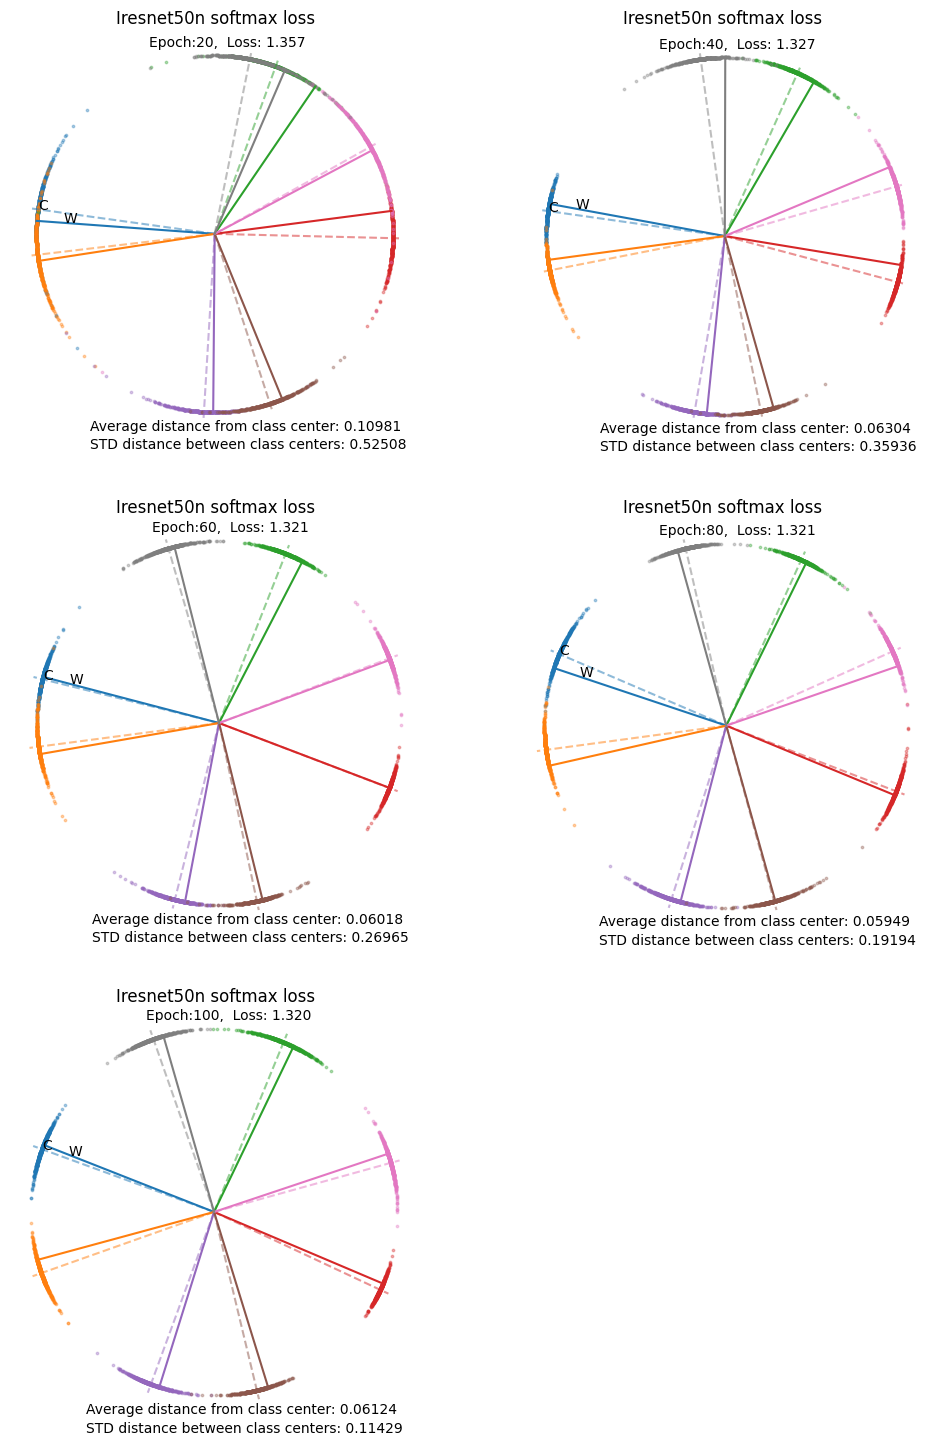

In [42]:
visualize(softmax_predict_data)

## Реализация модели с функцией потерь Triplet Loss  

## Triplet Loss

Для обучения модели с помощью triplet loss'а нам понадобится другой датасет и немного другой модуль для модели. Более подробно об этом лоссе вы можете почитать в [статье](https://arxiv.org/abs/1503.03832).

Основная идея этого контрастивного подхода состоит в следующем. На этапе обучения из датасета формируются тройки объектов (картинок) $(x^{a}, x^{p}, x^{n})$ таким образом, чтобы $x^{a}$ и $x^{p}$ принадлежади одному классу, а $x^{a}$ и $x^{n}$ - разным. Затем модель $f$ обучается с помощью следующей функции потерь:

$$L = \sum_{i}{max\left(0, {\left(\|f(x_{i}^{a}) - f(x_{i}^{p})\|_{2}^{2} - \|f(x_{i}^{a}) - f(x_{i}^{n})\|_{2}^{2} + \alpha\right)}\right)},$$

который "сближает" представления пар картинок, принаджащих одному классу, и "отдаляет" представления пар картинок, принадлежащих разным классам. Близость представлений подразумевается по 2-метрике.

In [43]:
import random


class TripletDataset(Dataset):
    """Triplet dataset wrapper."""

    def __init__(self, root_dir: str, num_labels: int, test: bool = False) -> None:
        """Initialize ArcFace Dataset.

        :param root_dir: path to the folder containing face images
        :param num_labels: number of classes (people) to be used
        :param test: if True, create test dataset (no augmentations, no labels)
        """
        super().__init__()

        self.test = test

        # for test dataset, use default transformations (conver to torch.Tensor and normalize),
        # do not use augmentations
        if self.test:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )

        # for train dataset, add augmentations of images (Random horizontal flip)
        else:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )

        self.root_dir = root_dir
        path_imgrec = os.path.join(root_dir, "train.rec")
        path_imgidx = os.path.join(root_dir, "train.idx")

        # load pictures
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, "r")
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)

        self.imgidx = np.array(range(1, int(header.label[0])))

        # load or create labels
        labels_path = Path(root_dir) / "labels.npy"
        if labels_path.is_file():
            self.labels = np.load(labels_path)
        else:
            print("Listing labels...")
            labels = []
            for i in tqdm(range(len(self.imgidx))):
                idx = self.imgidx[i]
                s = self.imgrec.read_idx(idx)
                header, img = mx.recordio.unpack(s)
                label = header.label
                labels.append(int(label))
            self.labels = np.array(labels)
            # save labels
            np.save(labels_path, self.labels)

        unique_labels, unique_counts = np.unique(self.labels, return_counts=True)
        top_ids = np.argsort(unique_counts)[::-1][:num_labels]
        self.top_labels = unique_labels[top_ids]

        self.label_map = dict(
            zip(self.top_labels.tolist(), np.arange(len(self.top_labels)))
        )

        # store final images and labels
        final_images = []
        final_labels = []
        m = len(self.imgidx)

        for idx in tqdm(self.imgidx):
            # idx = self.imgidx[i]
            s = self.imgrec.read_idx(idx)
            header, img = mx.recordio.unpack(s)
            label = header.label
            ln = label
            if not isinstance(label, numbers.Number):
                label = label[0]
            label = self.label_map.get(int(label), 10)
            sample = mx.image.imdecode(img).asnumpy()

            if label < num_labels:
                final_images.append(sample)
                final_labels.append(label)

        self.images = np.array(final_images)
        self.labels = np.array(final_labels)
        self.index = np.array([i for i in range(len(self.images))])

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, Optional[int]]:
        """Get item of a dataset.

        :param index: index of an item
        :return:
            - a tuple (image, label) for the train dataset
            - image for tht test dataset
        """
        anchor_img = self.images[index]
        anchor_label = self.labels[index]

        if self.test:
            if self.transform is not None:
                anchor_img = self.transform(anchor_img)
            return anchor_img, torch.tensor(anchor_label, dtype=torch.long)
        else:
            positive_list = self.index[self.index != index][
                self.labels[self.index != index] == anchor_label
            ]
            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item]

            negative_list = self.index[self.index != index][
                self.labels[self.index != index] != anchor_label
            ]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item]
            if self.transform is not None:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
            return (
                anchor_img,
                positive_img,
                negative_img,
                torch.tensor(anchor_label, dtype=torch.long),
            )

    def __len__(self) -> int:
        """Return size of the dataset."""
        return len(self.index)

In [45]:
NUM_PEOPLE = 8

path_to_data = "data/ms1m_subset"

train_triplet_dataset = TripletDataset(path_to_data, num_labels=NUM_PEOPLE, test=False)
test_triplet_dataset = TripletDataset(path_to_data, num_labels=NUM_PEOPLE, test=True)

100%|██████████| 44705/44705 [00:40<00:00, 1116.51it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


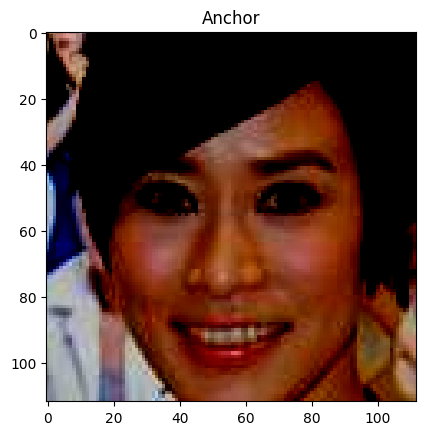

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


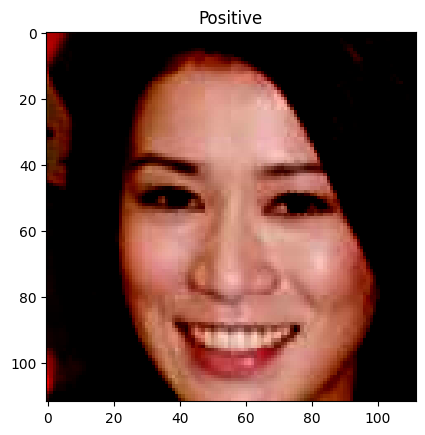

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


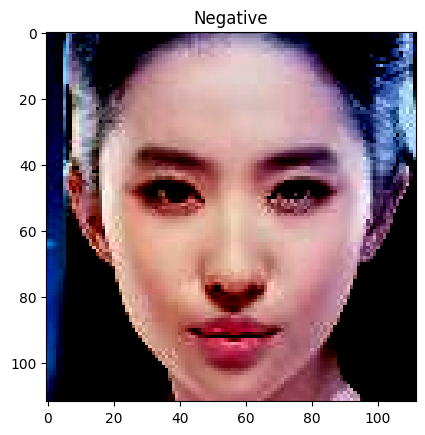

In [46]:
import matplotlib.pyplot as plt

# check triplets
anch, pos, neg, label = train_triplet_dataset[0]

plt.imshow(anch.transpose(0, 2).transpose(0, 1))
plt.title("Anchor")
plt.show()

plt.imshow(pos.transpose(0, 2).transpose(0, 1))
plt.title("Positive")
plt.show()

plt.imshow(neg.transpose(0, 2).transpose(0, 1))
plt.title("Negative")
plt.show()

In [47]:
batch_size = 80
num_workers = 0
train_loader = DataLoader(
    train_triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
test_loader = DataLoader(
    test_triplet_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

print(len(train_triplet_dataset))

4478


In [48]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(
        self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor
    ) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [49]:
from iresnet import iresnet50


class Net(torch.nn.Module):
    def __init__(
        self, num_features=128, trained_epochs: int = 0, model_name: str = "Model"
    ):
        super(Net, self).__init__()
        self.backbone = iresnet50(num_features=num_features)
        self.trained_epochs = trained_epochs
        self.model_name = model_name

    def forward(self, x):
        backbone_outputs = self.backbone(x)
        features = backbone_outputs["feature"]
        return features

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [51]:
iresnet50 = Net(num_features=2, model_name="Iresnet50 triplet loss").to(device)

In [52]:
optimizer = torch.optim.Adam(iresnet50.parameters(), lr=0.0001)
triplet_loss_fn = torch.jit.script(TripletLoss(margin=1.0))

In [53]:
def predict_features_t(
    model, test_dataloader: DataLoader, device: str = "cuda", loss=0
) -> Tuple[np.array, np.array]:
    model.to(device)
    model.eval()

    predicted_features = []
    image_labels = []

    for b, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        features = model(images.to(device))
        predicted_features.append(features.detach().cpu().numpy())
        image_labels.append(labels.numpy())

    predicted_features = np.concatenate(predicted_features)
    image_labels = np.concatenate(image_labels)

    return (
        predicted_features,
        image_labels,
        model.model_name,
        model.trained_epochs,
        loss,
    )

In [55]:
# Функция для обучения модели
def train_model(model, train_loader, loss_fn, opt, n_epochs, train_data):
    n_epochs_save = 20
    for epoch in tqdm(range(n_epochs), desc="Epochs"):
        running_loss = []
        model.train()
        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(
            train_loader
        ):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)

            opt.zero_grad()
            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)

            loss = loss_fn(anchor_out, positive_out, negative_out)
            loss.backward()
            opt.step()

            running_loss.append(loss.cpu().detach().numpy())
        avg_loss = np.mean(running_loss)
        print("Epoch: {}/{} - Loss: {:.4f}".format(epoch + 1, n_epochs, avg_loss))
        model.trained_epochs += 1

        if model.trained_epochs % n_epochs_save == 0:
            train_data.append(predict_features_t(model, test_loader, device, avg_loss))

In [56]:
triplet_loss_train_data = []

In [57]:
n_epochs = 40
train_model(
    iresnet50,
    train_loader,
    triplet_loss_fn,
    optimizer,
    n_epochs,
    triplet_loss_train_data,
)

Epochs:   0%|          | 0/40 [01:36<?, ?it/s]


KeyboardInterrupt: 

In [15]:
# Save model
model_file = "data/model_triplet_loss1.pt"
torch.save(iresnet50, model_file)

In [58]:
import pickle

In [59]:
dataset_path = "data/triplet_loss_train_data1.pkl"
with open(dataset_path, "wb") as f:
    pickle.dump(triplet_loss_train_data, f)

In [ ]:
with open(triplet_loss_train_data, "rb") as f:
    triplet_loss_train_data = pickle.load(f)

## Визуализация

In [ ]:
from scipy.spatial import distance


# Average distance between points and class center
def average_distance_t(features, image_labels):
    distances = []
    for i in np.unique(image_labels):
        points = features[image_labels == i]
        if points.shape[1] == 2:
            center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
        if points.shape[1] == 3:
            center = [
                np.mean(points[:, 0]),
                np.mean(points[:, 1]),
                np.mean(points[:, 2]),
            ]

        for point in points:
            distances.append(distance.euclidean(center, point))

    distances = np.array(distances)
    return distances[~np.isnan(distances)].mean()


colors = list(mcolors.TABLEAU_COLORS)[:8]


def visualize_t(data):
    n = len(data)
    rows = int(n / 2 + 1)
    plt.figure(figsize=(12, rows * 6))

    for c in range(n):
        ax = plt.subplot(rows, 2, c + 1)
        features, image_labels, title, epoch, loss = data[c]
        for i, color in zip(np.unique(image_labels), colors):
            points = features[image_labels == i]
            center = [np.mean(points[:, 0]), np.mean(points[:, 1])]
            ax.scatter(points[:, 0], points[:, 1], color=color, s=3, alpha=0.35)
            ax.scatter(
                center[0],
                center[1],
                color=color,
                s=6,
            )
            ax.scatter(center[0], center[1], color="k", s=6, alpha=0.35)
        plt.gca().set_aspect("equal")
        plt.axis("off")
        avg_distance = average_distance_t(features, image_labels)

        ax.text(
            0,
            0,
            "Average distance from class center: %.5f" % (avg_distance),
            transform=ax.transAxes,
        )

        plt.title(title)
        ax.text(
            0, 0.98, s="Epoch:%d,  Loss: %.3f" % (epoch, loss), transform=ax.transAxes
        )
    plt.show()

In [ ]:
visualize_t(triplet_loss_train_data[:7:2])

## 6. Решение задачи верификации на наборе данных EasyPortrait
Давайте возьмём набор данных [EasyPortrait](https://github.com/ai-forever/easyportrait), сформулируем для него задачу верификации и решим её с помощью предобученной ArcFace модели. 

### Подготовка данных

In [7]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt


data_dir = Path("data/easy_portrait")
data_dir.mkdir(exist_ok=True, parents=True)
images_dir = data_dir / "images"
images_dir.mkdir(exist_ok=True)

In [61]:
#!wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/images.zip -O data/images.zip
#!unzip -q data/images.zip -d data/easy_portrait/images

In [62]:
# !wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/annotations.zip -O data/annotations.zip

# !unzip data/annotations.zip -d data/easy_portrait
# !unzip data/easy_portrait/meta.zip -d data/easy_portrait

#### Вычисление глубоких представлений

С помощью детектора лиц [SCRFD](https://arxiv.org/pdf/2105.04714.pdf) и [ArcFace](https://arxiv.org/abs/1801.07698) модели на базе [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html), обученной на наборе данных [WebFace600K](https://www.face-benchmark.org/download.html), получим представления лиц набора EasyPortrait.

In [1]:
import torch
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
    root="./data/insightface",
)
app.prepare(ctx_id=0, det_size=(640, 640))
img = ins_get_image("t1")
faces = app.get(img)
rimg = app.draw_on(img, faces)
cv2.imwrite("data/t1_output.jpg", rimg)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'cudnn_conv_use_max_workspace': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_alloc': '0', 'device_id': '0'}}
find model: ./data/insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'cudnn_conv_use_max_workspace': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_alloc': '0', 'device_id': '0'}}
find model: ./d

/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


True

## Вычисление векторных представлений

In [8]:
face_meta = pd.read_csv("data/easy_portrait/meta.csv")

image_paths = []
user_ids = []
embeddings = []
for i, record in tqdm(face_meta.iterrows(), total=20000):
    if record["test"] is True:
        subset = "test"
    if record["train"] is True:
        subset = "train"
    if record["valid"] is True:
        subset = "val"
    image_path = str(images_dir / subset / (record["attachment_id"] + ".jpg"))
    image = cv2.imread(image_path)
    faces = app.get(image)

    if len(faces) == 1:
        image_paths.append(image_path)
        user_ids.append(record["user_id"])
        embeddings.append(faces[0].normed_embedding[np.newaxis, :])
embeddings = np.concatenate(embeddings)

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
  1%|          | 127/20000 [00:11<31:14, 10.60it/s]


KeyboardInterrupt: 

In [10]:
# save embeddings and meta data
embeddings_dir = Path("data/embeddings")
# embeddings_dir.mkdir(exist_ok=True)
# np.save(embeddings_dir / "image_paths.npy", np.array(image_paths))
# np.save(embeddings_dir / "user_ids.npy", np.array(user_ids))
# np.save(embeddings_dir / "embeddings.npy", embeddings)

## Определение протокола верификации

Множество изображений для каждого человека разобъём на 2 равных случайных шаблона, которые затем будем использовать для подсчёта точности верификации. 

Мы хотим составить список пар изображение, среди которых будут пары изображений одного и того же человека и изображения разных людей.  
Для составления негативных пар возьмём из каждого шаблона по одному изображению и выпишем множество всевозможных пар шаблонов.  
Для составления позитивных пар возьмём всевозможные пары в шаблоне для каждого человека.

In [11]:
user_ids = np.load(embeddings_dir / "user_ids.npy")
embeddings = np.load(embeddings_dir / "embeddings.npy")
image_paths = np.load(embeddings_dir / "image_paths.npy")

face_meta = pd.DataFrame(
    {
        "user_id": user_ids,
        "image_path": image_paths,
        "embedding_id": np.arange(len(embeddings)),
    }
)

In [12]:
face_meta

,user_id,image_path,embedding_id
0,1b70f339783ae94172ae47ae511aeb92,data/easy_portrait/images/test/de81cc1c-25f3-4...,0
1,cf16af42fb366a16face9a6f480d8654,data/easy_portrait/images/test/d17ca986-8ae1-4...,1
2,f8affcd943ce3dc5d7040bd499c8bfd3,data/easy_portrait/images/val/4b99a894-aa73-43...,2
3,9c340400bc5aef3e54e932d2320b33f6,data/easy_portrait/images/test/d68f7657-fb0c-4...,3
4,c60b1ae97ab03e6a5cc7dde77af527da,data/easy_portrait/images/train/f3307095-20cf-...,4
...,...,...,...
19677,0bf8258e9c1602253cb4e1ac7cda963c,data/easy_portrait/images/train/c9b6fdbc-9164-...,19677
19678,4a70a8aebc478ca9e2393e00253fceca,data/easy_portrait/images/test/ab661d04-3058-4...,19678
19679,49efc176ab5bbdb15f059eac0e474dea,data/easy_portrait/images/train/5793c68f-1b82-...,19679
19680,d6f605b57c3cfb6989d9aa48c1a61a85,data/easy_portrait/images/train/0362d137-21b4-...,19680


In [14]:
# split images to templates
seed = 0
rs = np.random.default_rng(seed)

template_ids = []
template_user_ids = []
template_emb_ids = []
for i, (user_id, user_data) in enumerate(face_meta.groupby("user_id")):
    if user_data.user_id.values[0] == "nan":
        continue
    num_images = len(user_data)
    if num_images == 1:
        # single image template
        template_ids += [2 * i]
        template_user_ids += [user_id]
        template_emb_ids += user_data["embedding_id"].values.tolist()
    else:
        # split template in two random halves
        random_order_ids = rs.permutation(num_images)
        first_template_data = user_data.iloc[random_order_ids[: num_images // 2]]
        second_template_data = user_data.iloc[random_order_ids[num_images // 2 :]]
        template_ids += [2 * i] * len(first_template_data)
        template_ids += [2 * i + 1] * len(second_template_data)

        template_user_ids += first_template_data["user_id"].values.tolist()
        template_user_ids += second_template_data["user_id"].values.tolist()

        template_emb_ids += first_template_data["embedding_id"].values.tolist()
        template_emb_ids += second_template_data["embedding_id"].values.tolist()
templates = pd.DataFrame(
    {
        "template_id": template_ids,
        "user_id": template_user_ids,
        "embedding_id": template_emb_ids,
    }
)
templates.to_csv(embeddings_dir / "templates.csv", index=False)

In [17]:
templates.iloc[40:100]

,template_id,user_id,embedding_id
40,32,0066d73e639db01860f18079de8ffada,12680
41,32,0066d73e639db01860f18079de8ffada,13837
42,32,0066d73e639db01860f18079de8ffada,14944
43,32,0066d73e639db01860f18079de8ffada,14641
44,32,0066d73e639db01860f18079de8ffada,6432
45,33,0066d73e639db01860f18079de8ffada,11719
46,33,0066d73e639db01860f18079de8ffada,3165
47,33,0066d73e639db01860f18079de8ffada,17599
48,33,0066d73e639db01860f18079de8ffada,2546
49,33,0066d73e639db01860f18079de8ffada,16571


In [18]:
# list positive and negative pairs

templates = pd.read_csv(embeddings_dir / "templates.csv")

In [19]:
first_template_positive = []
second_template_positive = []


# add positive pairs
for i, (user_id, user_data) in enumerate(templates.groupby("user_id")):
    unique_templates = user_data["template_id"].unique()
    if len(unique_templates) == 1:
        continue
    else:
        assert len(unique_templates) == 2
        first_template_positive += [unique_templates[0]]
        second_template_positive += [unique_templates[1]]

# add negative pairs
# from each subject first template is taken to match with others
user_to_template_id = {}
for i, (user_id, user_data) in enumerate(templates.groupby("user_id")):
    unique_templates = user_data["template_id"].unique()
    user_to_template_id[user_id] = unique_templates[0]
unique_user_ids = templates["user_id"].unique()

first_template_negative = []
second_template_negative = []

for first_id in tqdm(unique_user_ids):
    for second_id in unique_user_ids:
        if second_id == first_id:
            continue
        first_template_negative.append(user_to_template_id[first_id])
        second_template_negative.append(user_to_template_id[second_id])

100%|██████████| 8262/8262 [00:27<00:00, 300.90it/s]


In [20]:
first_template_negative = np.array(first_template_negative)
second_template_negative = np.array(second_template_negative)
first_template_positive = np.array(first_template_positive)
second_template_positive = np.array(second_template_positive)

In [21]:
len(first_template_positive), len(first_template_negative)

(2712, 68252382)

In [22]:
negative_pair_size = 5000000
seed = 0
rs = np.random.default_rng(seed)
random_order_ids = rs.permutation(len(first_template_negative))
negative_ids = random_order_ids[:negative_pair_size]
first_template = np.concatenate(
    [first_template_positive, first_template_negative[negative_ids]]
)
second_template = np.concatenate(
    [second_template_positive, second_template_negative[negative_ids]]
)
is_positive = [True] * len(first_template_positive) + [False] * len(negative_ids)

pairs = pd.DataFrame(
    {
        "first_template": first_template,
        "second_template": second_template,
        "is_positive": is_positive,
    }
)
pairs.to_csv(embeddings_dir / "pairs.csv", index=False)

### Подсчёт метрик точности верификации

In [23]:
pairs = pd.read_csv(embeddings_dir / "pairs.csv")
templates = pd.read_csv(embeddings_dir / "templates.csv")
embeddings = np.load(embeddings_dir / "embeddings.npy")

In [24]:
templates

,template_id,user_id,embedding_id
0,0,000846d038cc6289acf99f0739820896,3089
1,1,000846d038cc6289acf99f0739820896,5996
2,2,00099c87ff8a19643dbd31bf93bb1436,15643
3,4,00144dc200f186ef726669e9cd1332b7,5514
4,6,00147a746157ebb329c05140a2bf2517,7738
...,...,...,...
19551,16515,ffca0a846eea5f01deeab72e9f407428,15568
19552,16516,ffce02f942d36b6338290d0580dcb779,10100
19553,16518,ffddd372a507d5c234343da1af4a23c9,16191
19554,16520,fff39c130e0a6cbad6f96964f1756b73,16946


In [25]:
# pool template embs
template_pooled_embs = []
for i, (template_id, template_data) in enumerate(templates.groupby("template_id")):
    emb_ids = template_data["embedding_id"].values
    template_embeddinds = embeddings[emb_ids]
    mean_emb = np.mean(template_embeddinds, axis=0, keepdims=True)
    template_pooled_embs.append(mean_emb / np.linalg.norm(mean_emb))
template_pooled_embs = np.concatenate(template_pooled_embs)

In [26]:
unique_templates = templates["template_id"].unique()
template2id = np.zeros(max(unique_templates) + 1, dtype=int)
template2id[unique_templates] = np.arange(len(unique_templates))


def distance_function(X_1, X_2):
    return np.sum(X_1 * X_2, axis=1)


p1 = pairs["first_template"].values
p2 = pairs["second_template"].values

batch_size = 10000
steps = int(np.ceil(len(p1) / batch_size))
scores = []
for id in tqdm(range(steps), "Verification"):
    feat1 = template_pooled_embs[
        template2id[p1[id * batch_size : (id + 1) * batch_size]]
    ]
    feat2 = template_pooled_embs[
        template2id[p2[id * batch_size : (id + 1) * batch_size]]
    ]
    scores.extend(distance_function(feat1, feat2))
scores = np.array(scores)

Verification:   0%|          | 0/501 [00:00<?, ?it/s]

Verification: 100%|██████████| 501/501 [00:11<00:00, 42.68it/s]


In [27]:
def draw_score_distr_plot(scores_distr, positive_pair_name, negative_pair_name):
    sns.set_theme()
    plt.figure(figsize=(12, 8))
    sns.distplot(
        scores_distr[positive_pair_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=positive_pair_name,
    )
    sns.distplot(
        scores_distr[negative_pair_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=negative_pair_name,
    )

    plt.xlabel(f"Косинусная схожесть")

    plt.legend()

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


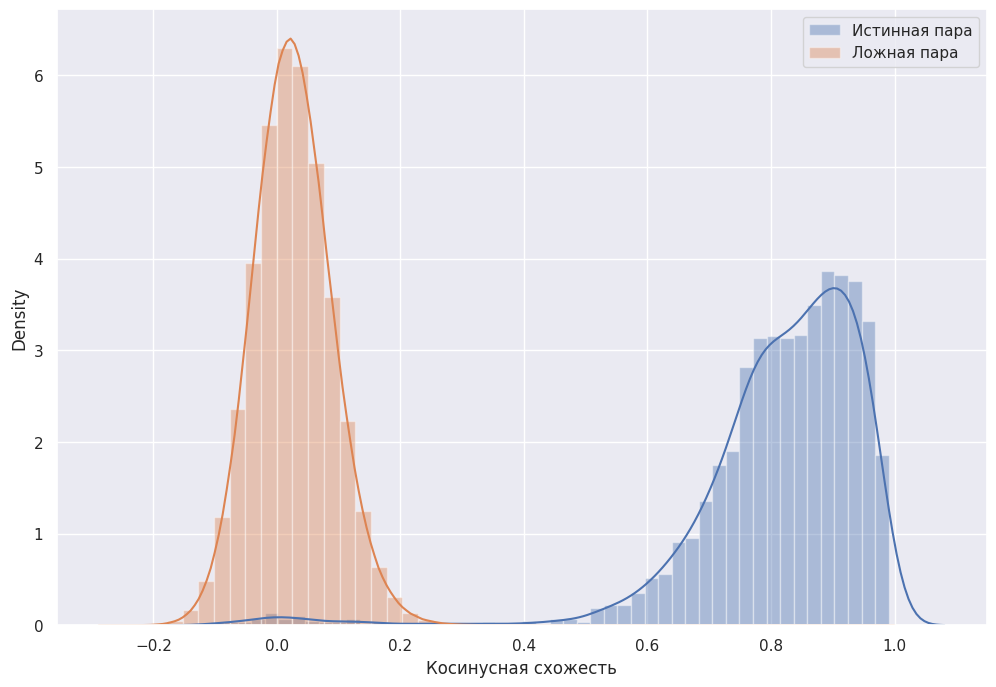

In [28]:
is_positive = pairs["is_positive"].values

true_match_scores = scores[is_positive]
wrong_match_scores = scores[is_positive == 0]
scores_distr = {
    "Истинная пара": true_match_scores,
    "Ложная пара": wrong_match_scores,
}
draw_score_distr_plot(
    scores_distr=scores_distr,
    positive_pair_name="Истинная пара",
    negative_pair_name="Ложная пара",
)

### TAR@FAR кривая

In [29]:
fars = [10**ii for ii in np.arange(-6, 0, 4 / 100)] + [1]
threshes, recalls = [], []
wrong_match_scores_sorted = np.sort(wrong_match_scores)[::-1]
for far in fars:
    thresh = wrong_match_scores_sorted[
        max(int((wrong_match_scores_sorted.shape[0]) * far) - 1, 0)
    ]
    recall = np.sum(true_match_scores > thresh) / true_match_scores.shape[0]
    threshes.append(thresh)
    recalls.append(recall)

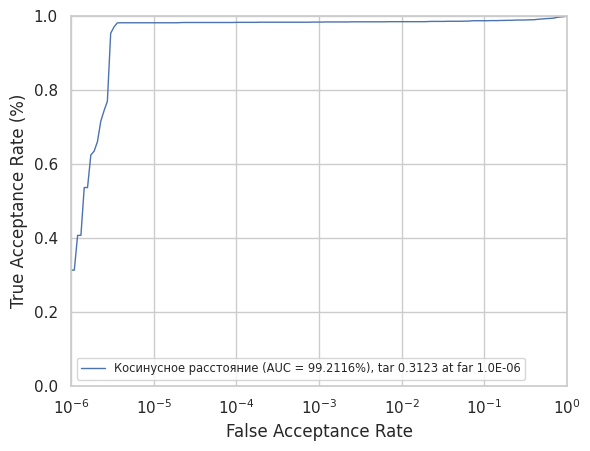

In [30]:
from sklearn.metrics import auc

sns.set_style("whitegrid")
fig = plt.figure()

auc_value = auc(fars, recalls)
label = "%s (AUC = %0.4f%%), tar %0.4f at far %.1E" % (
    "Косинусное расстояние",
    auc_value * 100,
    recalls[0],
    fars[0],
)
plt.plot(fars, recalls, lw=1, label=label)

plt.xlabel("False Acceptance Rate")
plt.xlim([fars[0], 1])
plt.xscale("log")
plt.ylabel("True Acceptance Rate (%)")
plt.ylim([0, 1])

# plt.grid(linestyle="--", linewidth=1)
plt.legend(fontsize="x-small")
# plt.tight_layout()
plt.show()